# **The Integrated Pipeline**

This combined our trained Custom CNN and MobileNetV2 architectures into a one pipeline. It implements a logic where the binary model acts as an initial filter for organic waste, ensuring that only potential recyclables are forwarded to the deeper multiclass model for specific material identification. This approach mimics real-world sorting workflows, allowing us to see the performance on unseen data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import glob

In [ ]:
!unzip test.zip -d test

Archive:  test.zip
   creating: test/test/
  inflating: test/test/R_8736.jpg    
  inflating: test/__MACOSX/test/._R_8736.jpg  
  inflating: test/test/R_6928.jpg    
  inflating: test/__MACOSX/test/._R_6928.jpg  
  inflating: test/test/R_6929.jpg    
  inflating: test/__MACOSX/test/._R_6929.jpg  
  inflating: test/test/R_3063.jpg    
  inflating: test/__MACOSX/test/._R_3063.jpg  
  inflating: test/test/R_3062.jpg    
  inflating: test/__MACOSX/test/._R_3062.jpg  
  inflating: test/test/R_8848.jpg    
  inflating: test/__MACOSX/test/._R_8848.jpg  
  inflating: test/test/R_334.jpg     
  inflating: test/__MACOSX/test/._R_334.jpg  
  inflating: test/test/R_8849.jpg    
  inflating: test/__MACOSX/test/._R_8849.jpg  
  inflating: test/test/R_3061.jpg    
  inflating: test/__MACOSX/test/._R_3061.jpg  
  inflating: test/test/R_1639.jpg    
  inflating: test/__MACOSX/test/._R_1639.jpg  
  inflating: test/test/R_8812.jpg    
  inflating: test/__MACOSX/test/._R_8812.jpg  
  inflating: test/test/

In [ ]:
PATH_TO_BINARY_MODEL = "/content/drive/MyDrive/Year 3/y3_1/AIML/aiml group project/binary_model.keras"
PATH_TO_MULTICLASS_MODEL = "/content/drive/MyDrive/Year 3/y3_1/AIML/aiml group project/mobilenetv2_model.keras"
TEST_IMAGES_DIR = 'test/test/*.jpg'

BINARY_LABELS = {0: 'Organic', 1: 'Recyclable'}
MULTICLASS_LABELS = {0: 'Cardboard', 1: 'Glass', 2: 'Metal', 3: 'Paper', 4: 'Plastic'}

In [ ]:
# load model
binary_model = tf.keras.models.load_model(PATH_TO_BINARY_MODEL)
multiclass_model = tf.keras.models.load_model(PATH_TO_MULTICLASS_MODEL)

# Data Preprocessing
Before any prediction, raw images are loaded and resized to $224 \times 224$ pixels to match the input shape the models expect. I also normalize the pixel values (scaling them between 0 and 1) to ensure the neural networks interpret the image data correctly.

In [ ]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    return img, img_array

# Stage 1: Binary Filtering

The processed image is first fed into our Binary Model. This model outputs a probability score indicating whether the object is Organic or Recyclable.

**Logic**: I apply a decision threshold to this score. If the model is confident the item is Organic, the pipeline stops immediately, classifying it as "Organic." This mimics a real-world system where biodegradable waste is separated first to prevent contamination.

# Stage 2: Material Classification

If the first model flags the item as Recyclable, the image is passed to the second model, MobileNetV2.

**Logic**: This model, trained via Transfer Learning, performs a deeper analysis to categorize the specific material type (Plastic, Paper, Glass, Metal, or Cardboard).

In [ ]:
def integrated_prediction_pipeline(img_path, ax=None):
    original_img, processed_img = preprocess_image(img_path)

    # 1. binary
    binary_pred_prob = binary_model.predict(processed_img, verbose=0)[0][0]

    # Determine Binary Class
    if binary_pred_prob > 0.32:
        binary_class_index = 1
    else:
        binary_class_index = 0

    binary_label = BINARY_LABELS[binary_class_index]
    final_result = binary_label

    if binary_label == 'Organic':
        # If Organic, stop
        print(f"Image: {os.path.basename(img_path)} -> ORGANIC")

    elif binary_label == 'Recyclable':
        # If Recyclable, pass to Model 2
        multiclass_probs = multiclass_model.predict(processed_img, verbose=0)
        multiclass_index = np.argmax(multiclass_probs, axis=1)[0]
        multiclass_label = MULTICLASS_LABELS[multiclass_index]
        confidence = multiclass_probs[0][multiclass_index]

        final_result = f"{multiclass_label} ({binary_label})"
        print(f"Image: {os.path.basename(img_path)} -> {multiclass_label}")

    # Show image
    if ax is not None:
        ax.imshow(original_img)
        ax.set_title(final_result, fontsize=9)
        ax.axis('off')

# **Final Prediction & Visualization**

The system combines the results from both stages and displays the final label. I visualize these results in a grid to verify the system's performance on random real-world examples.

## ****Note on Performance Metrics**
Unlike our training and validation phases where I had labeled datasets to calculate exact accuracy percentages, these predictions were run on a new set of random images.

Since these images **do not** have pre-assigned labels, I cannot calculate a mathematical accuracy score for this specific batch.

## Performance
**Observation**: In this batch of 20 images, I observed a ~60% success rate (approx. 12/20 correct).

**Analysis**: This aligns with the external dataset testing (58.9% accuracy), confirming that real-world lighting and backgrounds ("domain shift") remain the biggest challenge for the model.

Processing 20 images...

Image: R_8736.jpg -> Metal
Image: R_144.jpg -> Plastic
Image: R_1640.jpg -> Metal
Image: R_6923.jpg -> Cardboard
Image: R_8812.jpg -> Glass
Image: O_12615.jpg -> ORGANIC
Image: R_8811.jpg -> Paper
Image: R_273.jpg -> Glass
Image: R_3873.jpg -> ORGANIC
Image: R_6922.jpg -> Glass
Image: R_8810.jpg -> Paper
Image: R_1639.jpg -> Plastic
Image: O_12612.jpg -> ORGANIC
Image: R_3871.jpg -> Glass
Image: O_12611.jpg -> Glass
Image: R_1634.jpg -> Glass
Image: R_3867.jpg -> Glass
Image: R_3061.jpg -> Paper
Image: R_6928.jpg -> Glass
Image: O_12610.jpg -> ORGANIC


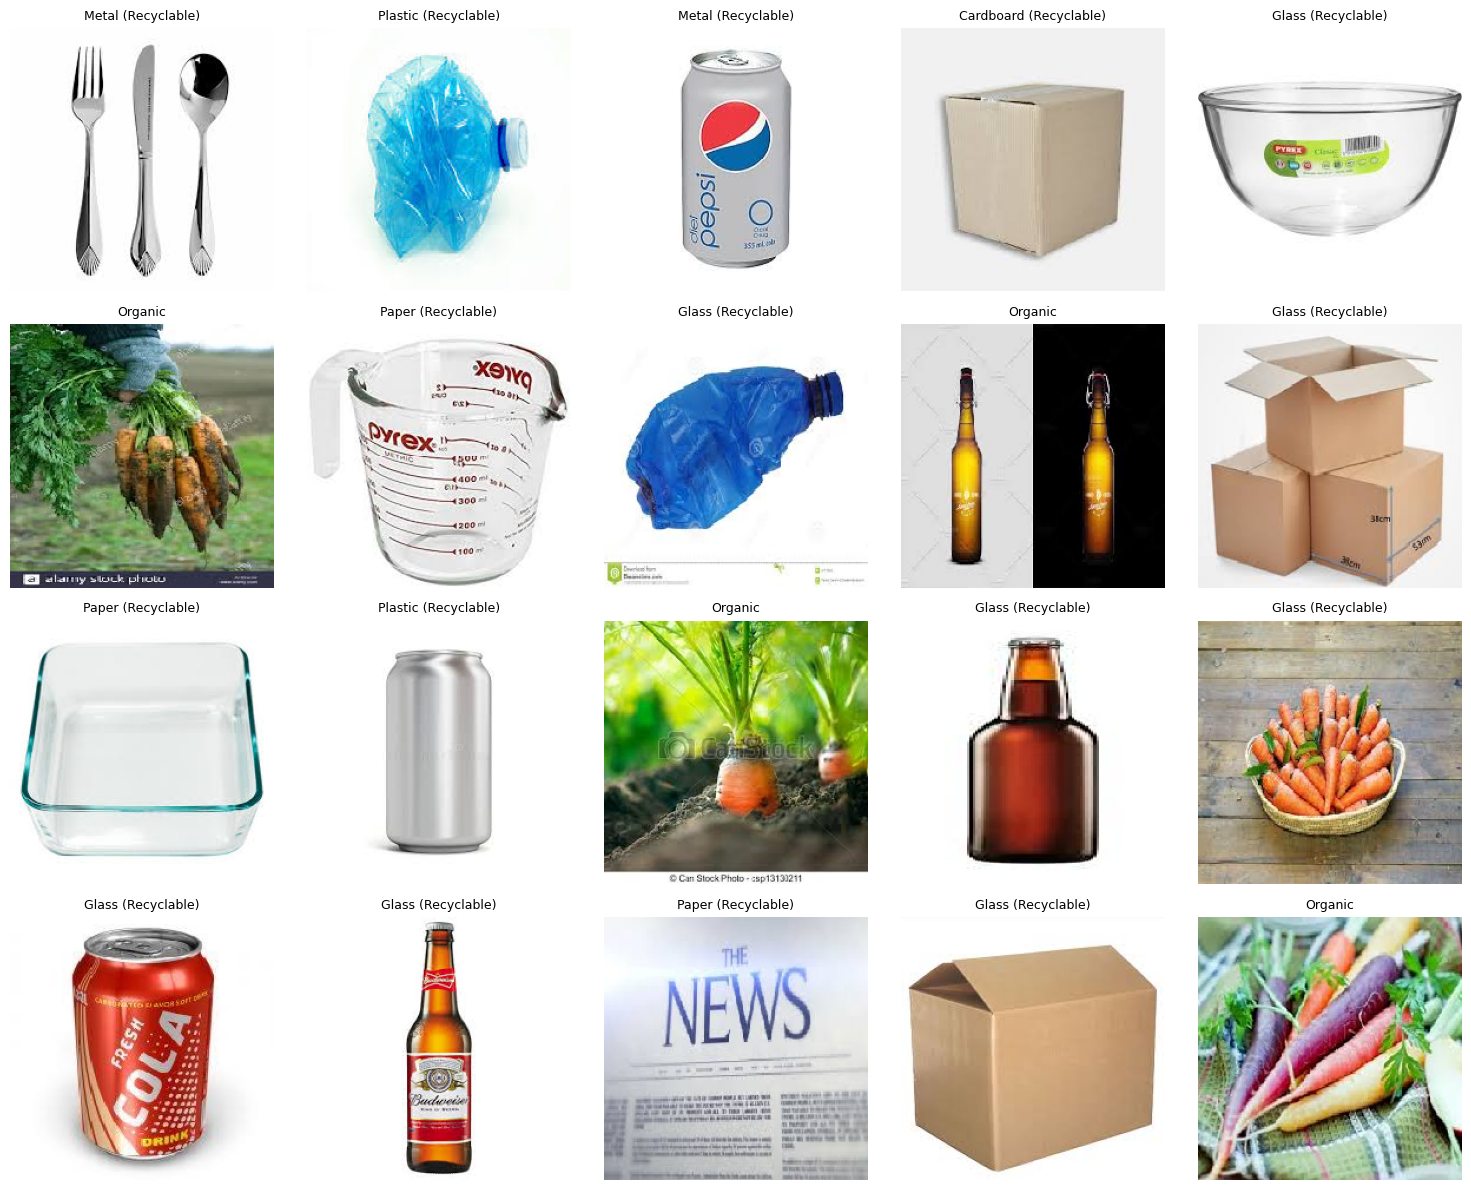

In [ ]:
all_images = glob.glob(TEST_IMAGES_DIR)
batch_images = all_images[:20]

if not batch_images:
    print("No images found! Check your TEST_IMAGES_DIR path.")
else:
    print(f"Processing {len(batch_images)} images...\n")

    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i, img_path in enumerate(batch_images):
        integrated_prediction_pipeline(img_path, ax=axes[i])

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()